# Condução de Calor Transiente Bidimensional
> Este post apresenta a resolução do problema de transferência de calor por meio do método das diferenças finitas, incluindo a discretização da equação governante e duas abordagens distintas para o gerenciamento de dados em Python, NumPy e Xarray.

- toc: true
- badges: true
- comments: true
- author: Felipe N. Schuch
- image: images/calor-2d-transiente.png
- categories: [Transferência de Calor, Métodos Numéricos, Xarray, NumPy]

# Introdução



O estudo de caso apresentado aqui, a condução de calor transiente bidimensional, tem um papel interessante, pois ele não é exatamente o objetivo deste texto, mas sim um meio.
Deixe-me explicar, dia desses me deparei com [Xarray](http://xarray.pydata.org/en/stable/) (formalmente *xray*), pacote Python que se destina a tornar o trabalho com arranjos de dados multidimensionais uma tarefa simples, eficiente e divertida.

**Xarray** introduz rótulos na forma de dimensões, coordenadas e atributos sobre os dados brutos dos arranjos em formato [NumPy](https://numpy.org/), permitindo uma experiência de desenvolvimento mais intuitiva, consistente e a prova de falhas.

Após ler a [documentação oficial](http://xarray.pydata.org/en/stable/), fiquei empolgado para ver como esse pacote funciona na prática, e fico feliz em compatilhar essa experiência com você.
Aqui entra o estudo da condução de calor transiente bidimensional, que será descrito a seguir.
Logo após, o problema será resolvido com estruturas de dados **NumPy**, para contextualizar o leitor com três abordagens diferentes, e então, o mesmo problema será resolvido com **Xarray** para comparação.


In [1]:
# Como sempre, o primeiro passo é importar
# os pacotes que vamos utilizar

# NumPy para manipulação de arranjos N-dimensionais
import numpy as np

# Matplotlib para graficar os resultados
import matplotlib.pyplot as plt

# Xarray, para testar o conceito dos rótulos
# na forma de dimensões, coordenadas e atributos
import xarray as xr

In [2]:
#hide

# Esse bloco modifica alguns dos valores padrões para
# apresentação das figuras

import matplotlib.pyplot as plt

plt.rcdefaults()

# https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('ggplot')

# https://matplotlib.org/3.1.1/tutorials/introductory/customizing.html
plt.rcParams.update({'figure.dpi' : 100,
                     "figure.figsize" : (6, 6),
                     "axes.formatter.limits" : (-8, 8)
                    })

# Descrição do Problema

Uma placa de cobre de \\( (L_x \times L_y) = ( 50 ~ cm \times 50 ~ cm ) \\) inicialmente possui temperatura em toda a sua extensão igual à \\( T_0 = 0^oC \\). 

Instantaneamente, a temperatura em suas bordas é elevada. Vamos admitir que cada um dos contornos tenha uma variação linear de acordo com a temperatura definida nos vértices da geometria, conforme mostra a figura a seguir:

![Regra do Trapézio](../images/transcal-transiente-bidimensional.jpeg)

Sabe-se que as propriedades do material são: Condutividade térmica \\( k = 52 ~ W/m \cdot K \\); Calor específico \\( c_p = 420 ~ J / kg \cdot K \\); Massa específica \\( \rho = 8.800 ~ kg / m^3 \\); Difusividade térmica \\( \alpha = k / (\rho c_p) \\).


Considerando um passo de tempo $\Delta t = 4 ~ s$ e a resolução espacial de $\Delta x = \Delta y = 5 ~ cm$, calcule a evolução da temperatura na placa até o tempo de $6.000 ~ s$.

Equação bidimensional que define a difusão de calor:

\\[
\dfrac{\partial T}{\partial t} = \alpha \left( \dfrac{\partial ^2 T}{\partial x^2} + \dfrac{\partial ^2 T}{\partial y^2} \right), \quad 0 \le x \le L_x, \quad 0 \le y \le L_y, \quad t \ge 0.
\\]

Condições de cortorno:

\\[
T_{x0} = T(x=0,y) = y \dfrac{T_d - T_a}{L_y} + T_a,
\\]
\\[
T_{xn} = T(x=L_x,y) = y \dfrac{T_b - T_c}{L_y} + T_c,
\\]
\\[
T_{y0} = T(x,y=0) = x \dfrac{T_c - T_a}{L_x} + T_a,
\\]
\\[
T_{yn} = T(x,y=Ly) = x \dfrac{T_b - T_d}{L_x} + T_d.
\\]

Condição inicial:

\\[
T(x,y) = T_0, \quad para \quad t=0.
\\]

Discretizando com a derivada segunda numa representação por diferença central e a derivada primeira com diferença ascendente temos:

\\[
\dfrac{T^{n+1}_{i,j}-T^{n}_{i,j}}{\Delta t}=\alpha \left[ \dfrac{T^{n}_{i-1,j}-2T^{n}_{i,j}+T^{n}_{i+1,j}}{(\Delta x)^2} +\dfrac{T^{n}_{i,j-1}-2T^{n}_{i,j}+T^{n}_{i,j+1}}{(\Delta y)^2}  \right], \quad 0 \le i \le I, \quad 0 \le j \le J, \quad n \ge 0,
\\]

\\[
T_{x0} =  y_j \dfrac{T_d - T_a}{L_y} + T_a, \quad para \quad i=0 \quad e \quad 0 \le j \le J,
\\]
\\[
T_{xn} = y_j \dfrac{T_b - T_c}{L_y} + T_c, \quad para \quad i=I \quad e \quad 0 \le j \le J,
\\]
\\[
T_{y0} = x_i \dfrac{T_c - T_a}{L_x} + T_a, \quad para \quad 0 \le i \le I \quad e \quad j=0,
\\]
\\[
T_{yn} = x_i \dfrac{T_b - T_d}{L_x} + T_d, \quad para \quad 0 \le i \le I \quad e \quad j=J,
\\]
\\[
T_{i,j}^n = T_0, \quad para \quad n=0.
\\]

Lembre-se que o critério de estabilidade numérica do problema é:

\\[
\Delta t \le \dfrac{\Delta x^2}{4 \alpha}.
\\]

# Desenvolvimento

Uma vez descrito o problema, partimos para a prática!
No bloco de código a seguir definimos todos os parâmetros físicos e numéricos que necessitamos:

In [3]:
# Propriedades do Material
k = 52.0 # W/mK
cp = 420.0 # J/kgK
rho = 8800.0 # kg/m^3

# Temperatura nos vértices
Ta = 60.
Tb = 20.
Tc = 0.
Td = 100.

# Temperatura inicial
T0 = 0.

# Discretização espacial
x = np.linspace(start = 0., stop = 0.5, num = 21, endpoint = True)
y = np.linspace(start = 0., stop = 0.5, num = 21, endpoint = True)
# e temporal
t = np.linspace(start = 0., stop = 6000., num = 601, endpoint = True)

Lembre-se que a documentação de qualquer função pode ser facilmente acessada sempre que surgir alguma dúvida sobre a sintaxe ou sobre os argumentos que ela aceita, basta digitar `help(np.linspace)`.

A partir daqui começa a resolução do problema:

In [4]:
# Cálculo da difusividade térmica
alpha = k / (rho * cp)

# Alocar a temperatura e impor condição inicial
T = T0 * np.ones((x.size,y.size,t.size))

# Condições de Contorno
Tx0 = (Td - Ta) / (y[-1] - y[0]) * y + Ta
Txn = (Tb - Tc) / (y[-1] - y[0]) * y + Tc
Ty0 = (Tc - Ta) / (x[-1] - x[0]) * x + Ta
Tyn = (Tb - Td) / (x[-1] - x[0]) * x + Td

# Aplicando as condições de contorno no tempo inicial
T[ 0 , : , 0] = Tx0
T[-1 , : , 0] = Txn
T[ : , 0 , 0] = Ty0
T[ : ,-1 , 0] = Tyn

# Passo de tempo e resolução da malha ao quadrado
dt, dx2, dy2 = t[1]-t[0], (x[1]-x[0])**2., (y[1]-y[0])**2.

# Estabilidade numérica
if dt <= np.minimum(dx2, dy2)/4./alpha:
  print('Critério de estabilidade satisfeito.')
else:
  print('Atenção! Critério de estabilidade não satisfeito.')

Critério de estabilidade satisfeito.


Bom, aqui fazemos uma observação quanto aos arranjos em NumPy, é preciso sempre ter em mente a maneira como foram definidos.
No caso da temperatura temos três coordenadas na ordem [x, y e t], ou [i, j e n] no espaço discreto. Portanto, ao aplicar ```T[0,:,0] = Tx0```, dizemos que `T` será igual à `Tx0` onde `i=0` e `n=0`, para todo o `j`, exatamente o que queremos para essa condição de contorno, o mesmo pode ser percebido nas demais superfícies. Lembre-se que em Python, o índice `-1` retoma o último elemento de uma dada dimensão.

Vamos definir uma função auxiliar para graficar os resultados obtidos, assim podemos facilmente repetir a produção de figuras para as diversas abordagens que usaremos.

In [5]:
def minha_figura(T, x, y):
  fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12,4))

  # Variação temporal da temperatura no centro da placa
  ax[0].plot(t, T[x.size//2,y.size//2,:])
  ax[0].set(
    xlabel='t [s]',
    ylabel=r'T [$^0C$]',
    title=f'x={x[x.size//2]} e y={y[y.size//2]}'
  )

  # E duas figuras para variação espacial:
  nfigs = 5
  for n in range(nfigs):
    time = n*((t.size)//(nfigs-1))
    # Variação com x e t para y fixo
    ax[1].plot(x, T[:,y.size//2,time], label=f't={t[time]}s')
    # Variação com y e t com x fixo
    ax[2].plot(y, T[x.size//2,:,time], label=f't={t[time]}s')

  # Adicionamos alguns detalhes visuais
  ax[1].set(xlabel='x [cm]', title=f'y={y[y.size//2]}')
  ax[2].set(xlabel='y [cm]', title=f'x={x[x.size//2]}')

  ax[1].legend(); ax[2].legend()

  plt.show();

## NumPy

O avanço no tempo se dá ao isolarmos o termo \\( T^{n+1}_{i,j} \\) na equação governante discreta, que então assume a forma:

\\[
T^{n+1}_{i,j} = T^{n}_{i,j} + \alpha \Delta t \left[ \dfrac{T^{n}_{i-1,j}-2T^{n}_{i,j}+T^{n}_{i+1,j}}{(\Delta x)^2} +\dfrac{T^{n}_{i,j-1}-2T^{n}_{i,j}+T^{n}_{i,j+1}}{(\Delta y)^2}  \right], \quad 0 \le i \le I, \quad 0 \le j \le J, \quad n \ge 0.
\\]

Perceba que quando `n=0`, todos os valores à direita da igualdade são conhecidos (nossa condição inicial), e assim, pode-se calcular o termo à esquerda, que será a temperatura em `n+1`.
Repetindo esse processo sucessivamente para cada valor de `i`, `j` e `n`, atingimos qualquer valor de tempo desejado, passo à passo.

A maneira mais intuitiva de programar a equação acima é escrevê-la exatamente como ela é, percorrendo todo o espaço bidimensional e o tempo por meio de três laços aninhados, e aplicando as condições de contorno ao final de cada passo de tempo:

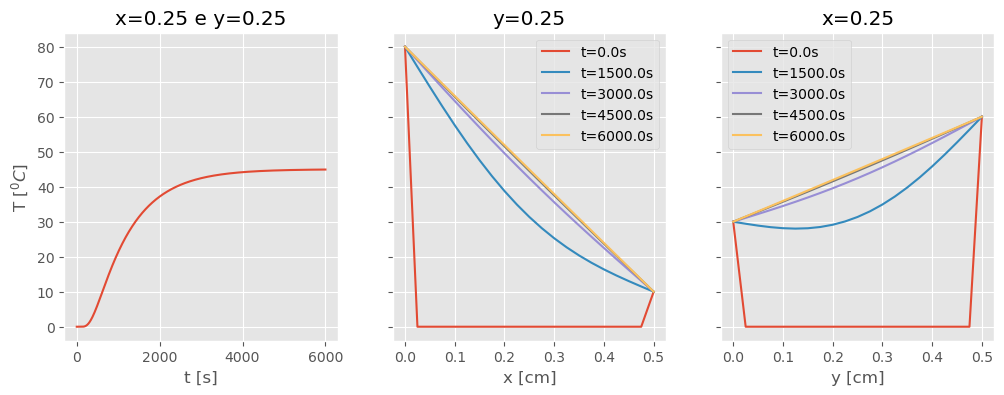

In [6]:
for n in range(t.size-1):
  for i in range(1,x.size-1):
    for j in range(1,y.size-1):
      T[i,j,n+1] = T[i,j,n] + alpha * dt * (
        (T[i-1,j  ,n] - 2. * T[i,j,n] + T[i+1,j  ,n]) / dx2 + 
        (T[i  ,j-1,n] - 2. * T[i,j,n] + T[i  ,j+1,n]) / dy2
      )
  # Condições de contorno
  T[0,:,n+1], T[-1,:,n+1], T[:,0,n+1], T[:,-1,n+1] = Tx0, Txn, Ty0, Tyn
  
minha_figura(T, x, y)

Note que no tempo nós já conhecemos a solução para `n=0`, então calculamos o laço temporal `t.size-1` vezes. De maneira similar, a temperatura é conhecida em todas as paredes, então não precisamos resolver a equação nos contornos, e assim, cada laço temporal exclui a primeira e a última posição (`range(1,x.size-1)`, por exemplo).

Embora o bloco de código acima resolva o problema, essa não é uma boa abordagem do ponto de vista do tempo necessário para o cálculo, ao realizar sequencialmente cada uma das operações por meio do aninhamento de laços.

Sobre **NumPy**, além do suporte para arranjos multi-dimensionais, toda a biblioteca é programada em C, então todas as operações com NumPy são preparadas para alto desempenho (computação vetorial e computação paralela). Temos o desempenho de uma linguagem compilada (C), dentro de um ambiente de linguagem interpretada (Python), o melhor de dois mundos. Para tirar proveito disso, o ideal é realizar as operações vetorialmente ao resolver o problema em *fatias* (mais informações [aqui](https://numpy.org/doc/stable/user/basics.indexing.html?highlight=slicing#other-indexing-options)), de modo que podemos reescrever o código como:

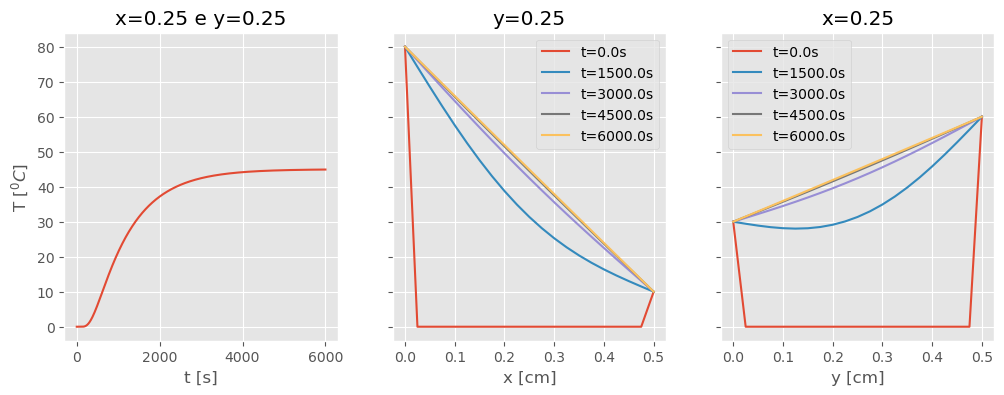

In [7]:
for n in range(t.size-1):
  T[1:-1,1:-1,n+1] = T[1:-1,1:-1,n] + dt * alpha * (
    (T[ :-2,1:-1,n] - 2. * T[1:-1,1:-1,n] + T[2:  ,1:-1,n]) / dx2 +
    (T[1:-1, :-2,n] - 2. * T[1:-1,1:-1,n] + T[1:-1,2:  ,n]) / dy2
  )
  # Condições de contorno
  T[0,:,n+1], T[-1,:,n+1], T[:,0,n+1], T[:,-1,n+1] = Tx0, Txn, Ty0, Tyn

minha_figura(T, x, y)

Temos exatamente a mesma resposta para um tempo de cálculo inferior. Bem, esse ganho de desempenho depende das características da sua máquina e do problema, talvez podem nem ser perceptíveis quando usamos apenas 21 pontos em cada direção espacial, mas experimente aumentar esses valores.

Uma terceira alternativa com **NumPy** é deixar com que suas funções embarcadas façam parte do trabalho, o pacote conta com diversos recursos para derivação, integração, interpolação, trigonometria e muitos outros.

Vale destacar que no momento não conheço nenhuma função **NumPy** que calcule a derivada segunda em um arranjo. De qualquer maneira, se admitirmos que a derivada segunda pode ser aproximada com a aplicação dupla da derivada primeira (lembre-se que embora analiticamente sejam equivalentes, numéricamente isso nem sempre é verdade), podemos usar a função [np.gradient](https://numpy.org/doc/1.18/reference/generated/numpy.gradient.html?highlight=gradient#numpy.gradient) para reescrever nosso código na forma:

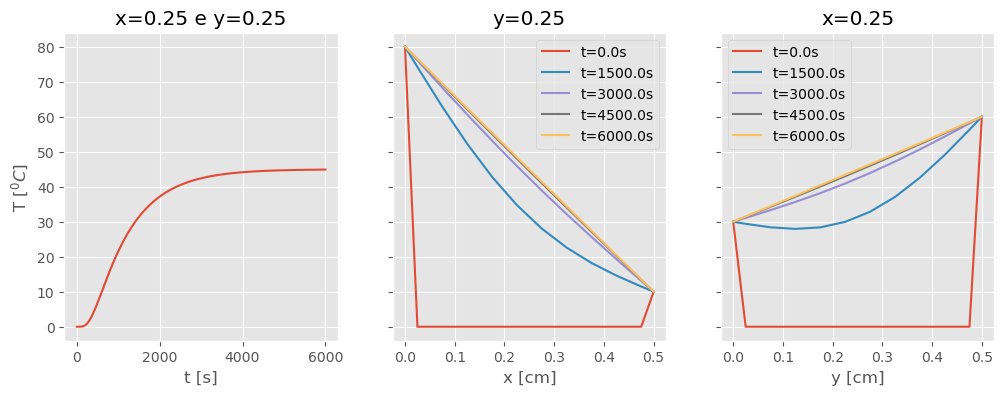

In [8]:
for n in range(t.size-1):
  T[:,:,n+1] = T[:,:,n] + dt * alpha * (
    np.gradient(np.gradient(T[:,:,n], x, axis=0), x, axis=0) +
    np.gradient(np.gradient(T[:,:,n], y, axis=1), y, axis=1)
  )
  # Condições de contorno
  T[0,:,n+1], T[-1,:,n+1], T[:,0,n+1], T[:,-1,n+1] = Tx0, Txn, Ty0, Tyn

minha_figura(T, x, y)

Essa abordagem pode não ser tão precisa quanto as que vimos anteriormente, mas a descrição de como implementar operadores diferenciais será assunto para um outro dia.
Por outro lado, se ainda assim e erro está em uma faixa tolerável para a sua aplicação, essa pode ser uma alternativa pela facilidade de aplicação e boa legibilidade do código.
Como qualquer outro arranjo **NumPy**, devemos lembrar de que definimos a temperatura na ordem [x, y e t], e assim, `axis=0` resultará no gradiente na diração x, enquanto `axis=1` será o gradiente em y.

In [9]:
#hide
del T # Aqui liberamos um parte da memória

## Xarray

Uma vez realizada a contextualização, vamos agora abordar a transferência de calor transiente bidimencional com **Xarray**, um pacote para estruturas de dados rotulados N-dimensionais (também denominados tensores). A sua vantagem é permitir realizar operações empregrando o nome das coordenadas em vez da sua numeração (`dim='x'` em vez de `axis=0`), além de armazenar atributos como o nome e unidade das diversas variáveis.

O ganho imediato em usar **Xarray** é que escrevemos menos código. A longo prazo o ganho é a legibilidade, podemos entender o que estavamos pensando ao retomar para um código semanas ou meses depois.

Para exemplificar, vamos iniciar criando um `Dataset` para armazenar as informações do nosso problema. Existem diversos modos para isso, e uma leitura na [documentação oficial](http://xarray.pydata.org/en/stable/index.html) é recomendada. Com o seguinte bloco de código, inicializamos nosso sistema de coordenadas:

In [10]:
data = xr.Dataset(coords={
    'x': np.linspace(start = 0., stop = 0.5, num = 21, endpoint = True),
    'y': np.linspace(start = 0., stop = 0.5, num = 21, endpoint = True),
    't': np.linspace(start = 0., stop = 6000., num = 601, endpoint = True)
})

Ao contrário do exemplo anterior em **Numpy** onde tinhamos as três variáveis (`x`, `y` e `t`), aqui toda a informação está consolidada em uma única estrutura, que denominamos `data`. O acesso específico a cada uma delas ocorre de maneira similar a notação dos dicionários em Python, isso é, `data['x']`, ou ainda de maneira mais condensada como `data.x`, por exemplo.

Vamos adicionar atributos às nossas coordenadas para facilitar o entendimento do código, além disso, veremos que os atributos são automaticamente incluídos nas figuras, diminuindo nosso trabalho futuro. Aqui incluimos as unidades e denominamos `t` como  tempo:

In [11]:
data.x.attrs['units'] = 'm'
data.y.attrs['units'] = 'm'
data.t.attrs['units'] = 's'
data.t.attrs['name'] = 'tempo'

Agora definimos a temperatura como um arranjo tridimensional (x, y e tempo) e também incluimos os atributos para referência:

In [12]:
data['T'] = xr.DataArray(0., coords=[data.x, data.y, data.t])

data.T.attrs['units'] = '°C'
data.T.attrs['name'] = 'Temperatura'

E as propriedades do material:

In [13]:
data['alpha'] = 1.407e-5

data.alpha.attrs['units'] = r'm$^2$/s'
data.alpha.attrs['name'] = 'Difusividade térmica'

Em um ambiente Jupyter Notebook interativo (como esse post), visualizamos facilmente todo o conteúdo e atributos da nossa estrutura de dados ao imprimi-la na tela (experimente clicar nos vários ícones):

In [14]:
data

<xarray.Dataset>
Dimensions:  (t: 601, x: 21, y: 21)
Coordinates:
  * x        (x) float64 0.0 0.025 0.05 0.075 0.1 ... 0.4 0.425 0.45 0.475 0.5
  * y        (y) float64 0.0 0.025 0.05 0.075 0.1 ... 0.4 0.425 0.45 0.475 0.5
  * t        (t) float64 0.0 10.0 20.0 30.0 ... 5.97e+03 5.98e+03 5.99e+03 6e+03
Data variables:
    T        (x, y, t) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    alpha    float64 1.407e-05

Existe uma série de métodos para selecionar dados dentro dos nossos arranjos (mais informações [aqui](http://xarray.pydata.org/en/stable/indexing.html)), uma delas é por meio de dicionários. Por exemplo, para impor a condição inicial na temperatura podemos usar o dicionário `{'t' : 0}`, ou a notação equivalente `dict(t=0)`. De maneira análoga, iremos impor as condições de contorno, como vemos:

In [15]:
# Condição Inicial
data.T[dict(t=0)] = T0

# Condições de Contorno
data.T[dict(t=0,x=0)] = (Td - Ta) / (data.y[-1] - data.y[0]) * data.y + Ta
data.T[dict(t=0,x=-1)] = (Tb - Tc) / (data.y[-1] - data.y[0]) * data.y + Tc
data.T[dict(t=0,y=0)] = (Tc - Ta) / (data.x[-1] - data.x[0]) * data.x + Ta
data.T[dict(t=0,y=-1)] = (Tb - Td) / (data.x[-1] - data.x[0]) * data.x + Td

Se novamente admitirmos que a derivada segunda pode ser aproximada com a aplicação dupla da derivada primeira, resolvemos o problema com o seguinte bloco de código:

In [16]:
for n in range(data.t.size - 1):
  dt = data.t[n+1] - data.t[n]
  # Equação Governate
  data.T[dict(t=n+1)] = data.T[dict(t=n)] + dt * data.alpha * (
      data.T[dict(t=n)].differentiate('x').differentiate('x') +
      data.T[dict(t=n)].differentiate('y').differentiate('y')
  )
  # Condições de Contorno
  data.T[dict(t=n+1,x=0)] = data.T[dict(t=0,x=0)]
  data.T[dict(t=n+1,x=-1)] = data.T[dict(t=0,x=-1)]
  data.T[dict(t=n+1,y=0)] = data.T[dict(t=0,y=0)]
  data.T[dict(t=n+1,y=-1)] = data.T[dict(t=0,y=-1)]

Note a diferença visual em relação ao nosso exemplo anterior em **NumPy**, onde sempre derevemos lembrar da ordem de definição dos eixos para manipular os dados, como `np.gradient(T[:,:,n], x, axis=0)` para derivação da temperatura no tempo `n` em relação a x, com **Xarray** usamos simplesmente `data.T[dict(t=n)].differentiate('x')`.

Outra vantagem de usar **Xarray**, o pacote oferece uma série de funcionalidades gráficas, construídas sobre **Matplotlib** (mais informações [aqui](http://xarray.pydata.org/en/stable/plotting.html)), de modo que com poucas linhas de código podemos:

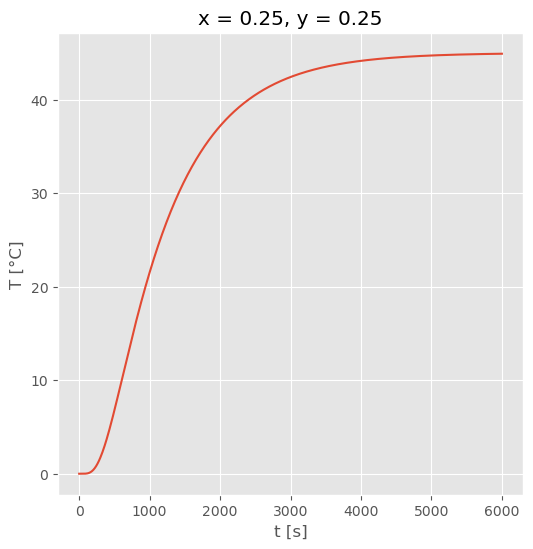

In [17]:
# Graficar a evolução temporal da temperatura no centro da placa
data.T.isel(x=data.x.size//2, y=data.y.size//2).plot.line();

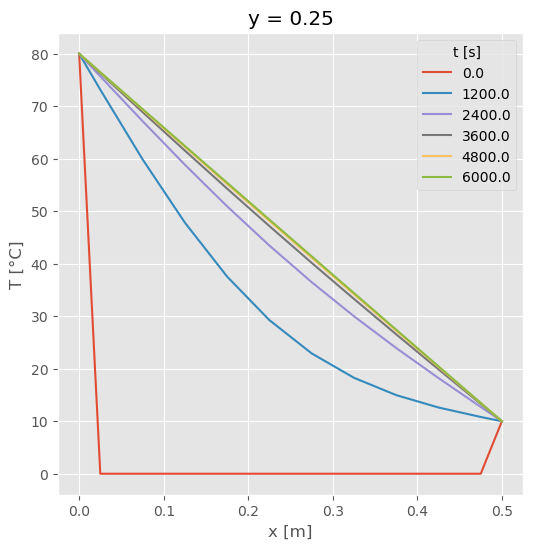

In [18]:
# Variação com x e t para y fixo
data.T.isel(t=slice(None,None,120), y=data.y.size//2).plot.line(x='x');

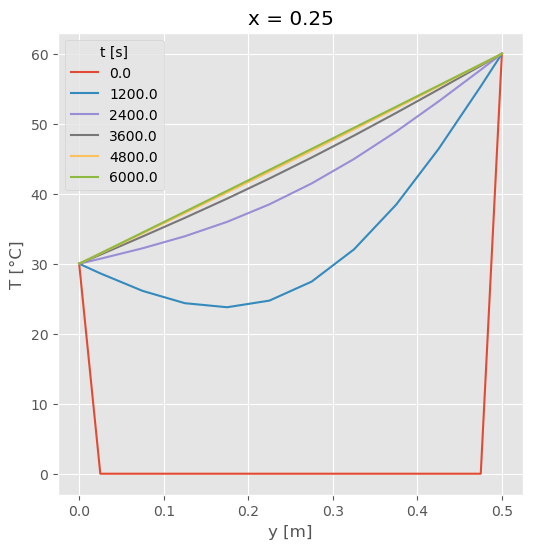

In [19]:
# Variação com y e t para x fixo
data.T.isel(t=slice(None,None,120), x=data.x.size//2).plot.line(x='y');

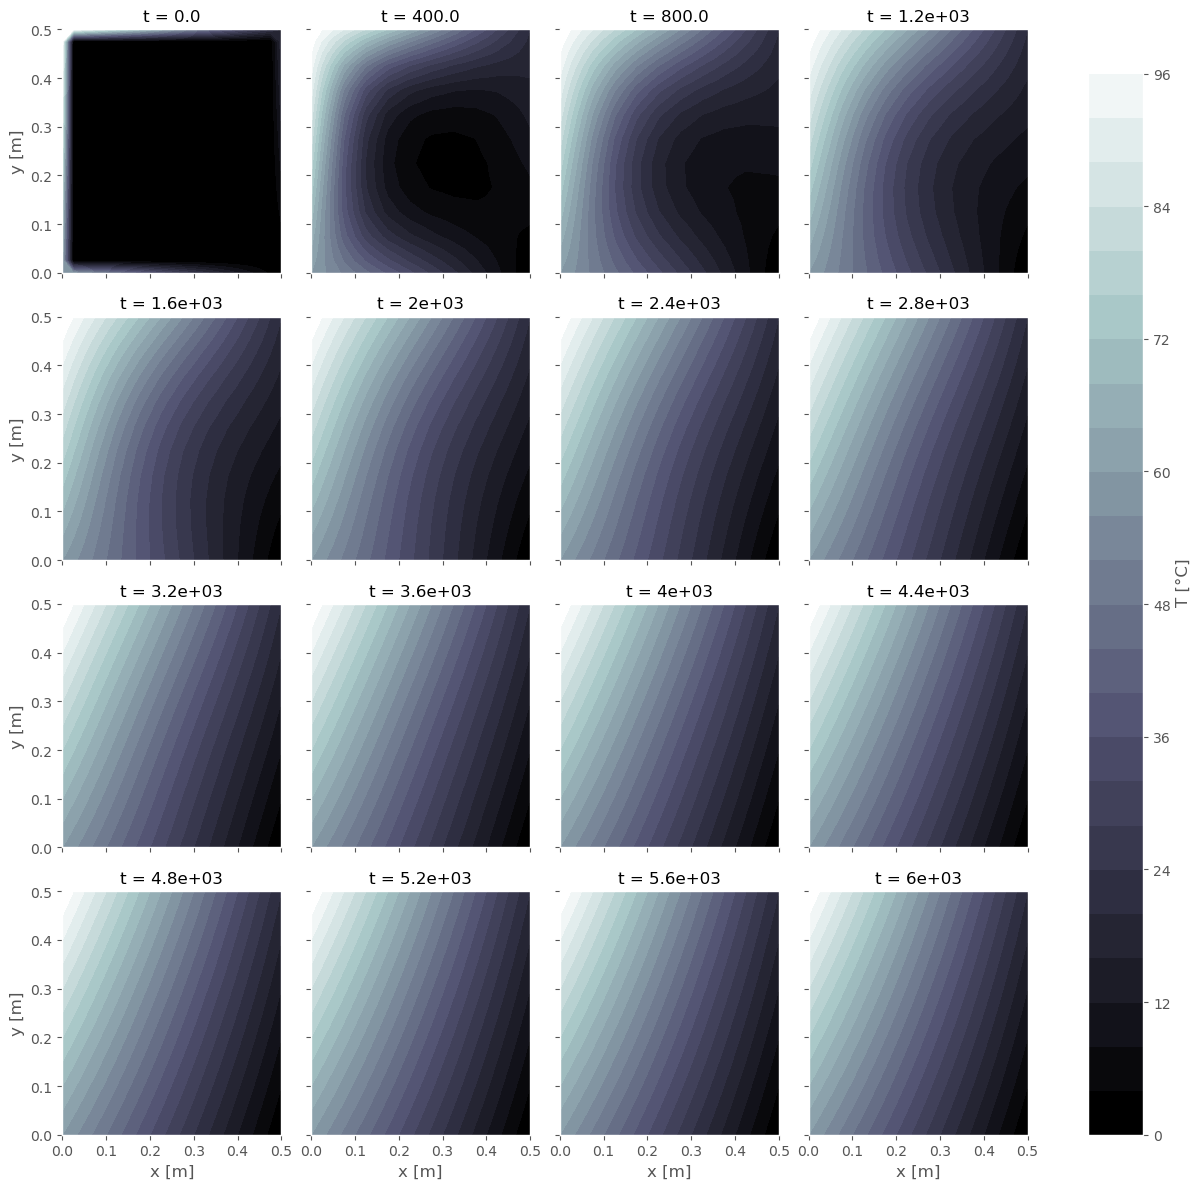

In [20]:
# E aqui temos a completa variação espaço-temporal
data.T.sel(t=slice(None,None,40)).T.plot.contourf(
  col='t',
  col_wrap=4,
  aspect = 1,
  cmap='bone',
  levels = 32
);

# Conclusão

Com esse estudo de caso, demonstrou-se como resolver a condução de calor bidimensional transiente empregando dois diferentes pacotes para manipulação de arranjos, **NumPy** e **Xarray**. Vimos como o primeiro funciona baseado na numeração dos diferentes eixos de coordenadas `axis=0`, enquanto o segundo utiliza rótulos `dim='x'`, em uma apresentação muito mais intuitiva e visual. Certamente, cada abordagem tem seus pontos fortes e fracos, e a escolha de uma ou outra depende do tipo de aplicação em questão e da preferência do próprio programador.